# Install Dependencies

Works best on google colab. If running locally, make sure it has CUDA support and and NVIDIA graphics card with at least 15 GB VRAM

In [1]:
%%capture
# Installs Unsloth, Xformers (Flash Attention) and all other packages!
!pip install "unsloth[colab-new] @ git+https://github.com/unslothai/unsloth.git"
!pip install --no-deps xformers "trl<0.9.0" peft accelerate bitsandbytes

# Unsloth 4 bit quantized Llama 3 Model

If using a different model, provide huggingface token and uncomment line 14, otherwise the model being used is the unsloth quantized model

For more info and troubleshooting go to the unsloth github repo [https://github.com/unslothai/unsloth](https://github.com/unslothai/unsloth)

In [2]:
from unsloth import FastLanguageModel
import torch
max_seq_length = 2048 # Choose any! We auto support RoPE Scaling internally!
# Note that the max is 8192 for llama 3 at any size model. Look out in the future for 16k and 32k context models
dtype = None # None for auto detection. Float16 for Tesla T4, V100, Bfloat16 for Ampere+
load_in_4bit = True # Use 4bit quantization to reduce memory usage. Can be False.



model, tokenizer = FastLanguageModel.from_pretrained(
    model_name = "unsloth/llama-3-8b-bnb-4bit",
    max_seq_length = max_seq_length,
    dtype = dtype,
    load_in_4bit = load_in_4bit,
    # token = "hf_...", # use one if using gated models like meta-llama/Llama-2-7b-hf
)

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
==((====))==  Unsloth: Fast Llama patching release 2024.6
   \\   /|    GPU: Tesla T4. Max memory: 14.748 GB. Platform = Linux.
O^O/ \_/ \    Pytorch: 2.3.0+cu121. CUDA = 7.5. CUDA Toolkit = 12.1.
\        /    Bfloat16 = FALSE. Xformers = 0.0.26.post1. FA = False.
 "-____-"     Free Apache license: http://github.com/unslothai/unsloth


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [3]:
model = FastLanguageModel.get_peft_model(
    model,
    r = 16, # Choose any number > 0 ! Suggested 8, 16, 32, 64, 128
    target_modules = ["q_proj", "k_proj", "v_proj", "o_proj",
                      "gate_proj", "up_proj", "down_proj",],
    lora_alpha = 16,
    lora_dropout = 0, # Supports any, but = 0 is optimized
    bias = "none",    # Supports any, but = "none" is optimized
    # [NEW] "unsloth" uses 30% less VRAM, fits 2x larger batch sizes!
    use_gradient_checkpointing = "unsloth", # True or "unsloth" for very long context
    random_state = 3407,
    use_rslora = False,  # We support rank stabilized LoRA
    loftq_config = None, # And LoftQ
)

Unsloth 2024.6 patched 32 layers with 32 QKV layers, 32 O layers and 32 MLP layers.


# Dataset

Data is loaded from a JSON file in the following form:

      [
          {
            instruction: "Do something with the input",
            input: "Some Input data",
            output: "some output"
          },
          {
            instruction: "Do something else with the input",
            input: "Some other data",
            output: "some output"
          },
          ......
      ]

In [4]:
alpaca_prompt = """Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.

### Instruction:
{}

### Input:
{}

### Response:
{}"""

EOS_TOKEN = tokenizer.eos_token # Must add EOS_TOKEN
def formatting_prompts_func(examples):
    instructions = examples["instruction"]
    inputs       = examples["input"]
    outputs      = examples["output"]
    texts = []
    for instruction, input, output in zip(instructions, inputs, outputs):
        # Must add EOS_TOKEN, otherwise your generation will go on forever!
        text = alpaca_prompt.format(instruction, input, output) + EOS_TOKEN
        texts.append(text)
    return { "text" : texts, }
pass

from datasets import load_dataset
dataset = load_dataset("json", data_files= "./sample_data/metro_input.json", split = "train")
dataset = dataset.map(formatting_prompts_func, batched = True,)

# Training Parameters

use max_steps if you want to only train on randomized subset of training data (shorter training)

Use num_train_epochs=1 to go over the entire training data once, 2 for twice etc... (takes longer)

If both parameters are used, max_steps overrides num_train_epochs

In [5]:
from trl import SFTTrainer
from transformers import TrainingArguments
from unsloth import is_bfloat16_supported

trainer = SFTTrainer(
    model = model,
    tokenizer = tokenizer,
    train_dataset = dataset,
    dataset_text_field = "text",
    max_seq_length = max_seq_length,
    dataset_num_proc = 2,
    packing = False, # Can make training 5x faster for short sequences.
    args = TrainingArguments(
        per_device_train_batch_size = 2,
        gradient_accumulation_steps = 4,
        warmup_steps = 5,
         #max_steps = 100,
        num_train_epochs = 1,
        learning_rate = 2e-4,
        fp16 = not is_bfloat16_supported(),
        bf16 = is_bfloat16_supported(),
        logging_steps = 1,
        optim = "adamw_8bit",
        weight_decay = 0.01,
        lr_scheduler_type = "linear",
        seed = 3407,
        output_dir = "outputs",
    ),
)

max_steps is given, it will override any value given in num_train_epochs


In [6]:
#@title Show current memory stats
gpu_stats = torch.cuda.get_device_properties(0)
start_gpu_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
max_memory = round(gpu_stats.total_memory / 1024 / 1024 / 1024, 3)
print(f"GPU = {gpu_stats.name}. Max memory = {max_memory} GB.")
print(f"{start_gpu_memory} GB of memory reserved.")

GPU = Tesla T4. Max memory = 14.748 GB.
5.594 GB of memory reserved.


# Begin Training
Look for a reduction in loss as training steps go on to determine if training is going well.

When graphed the loss should look like this:
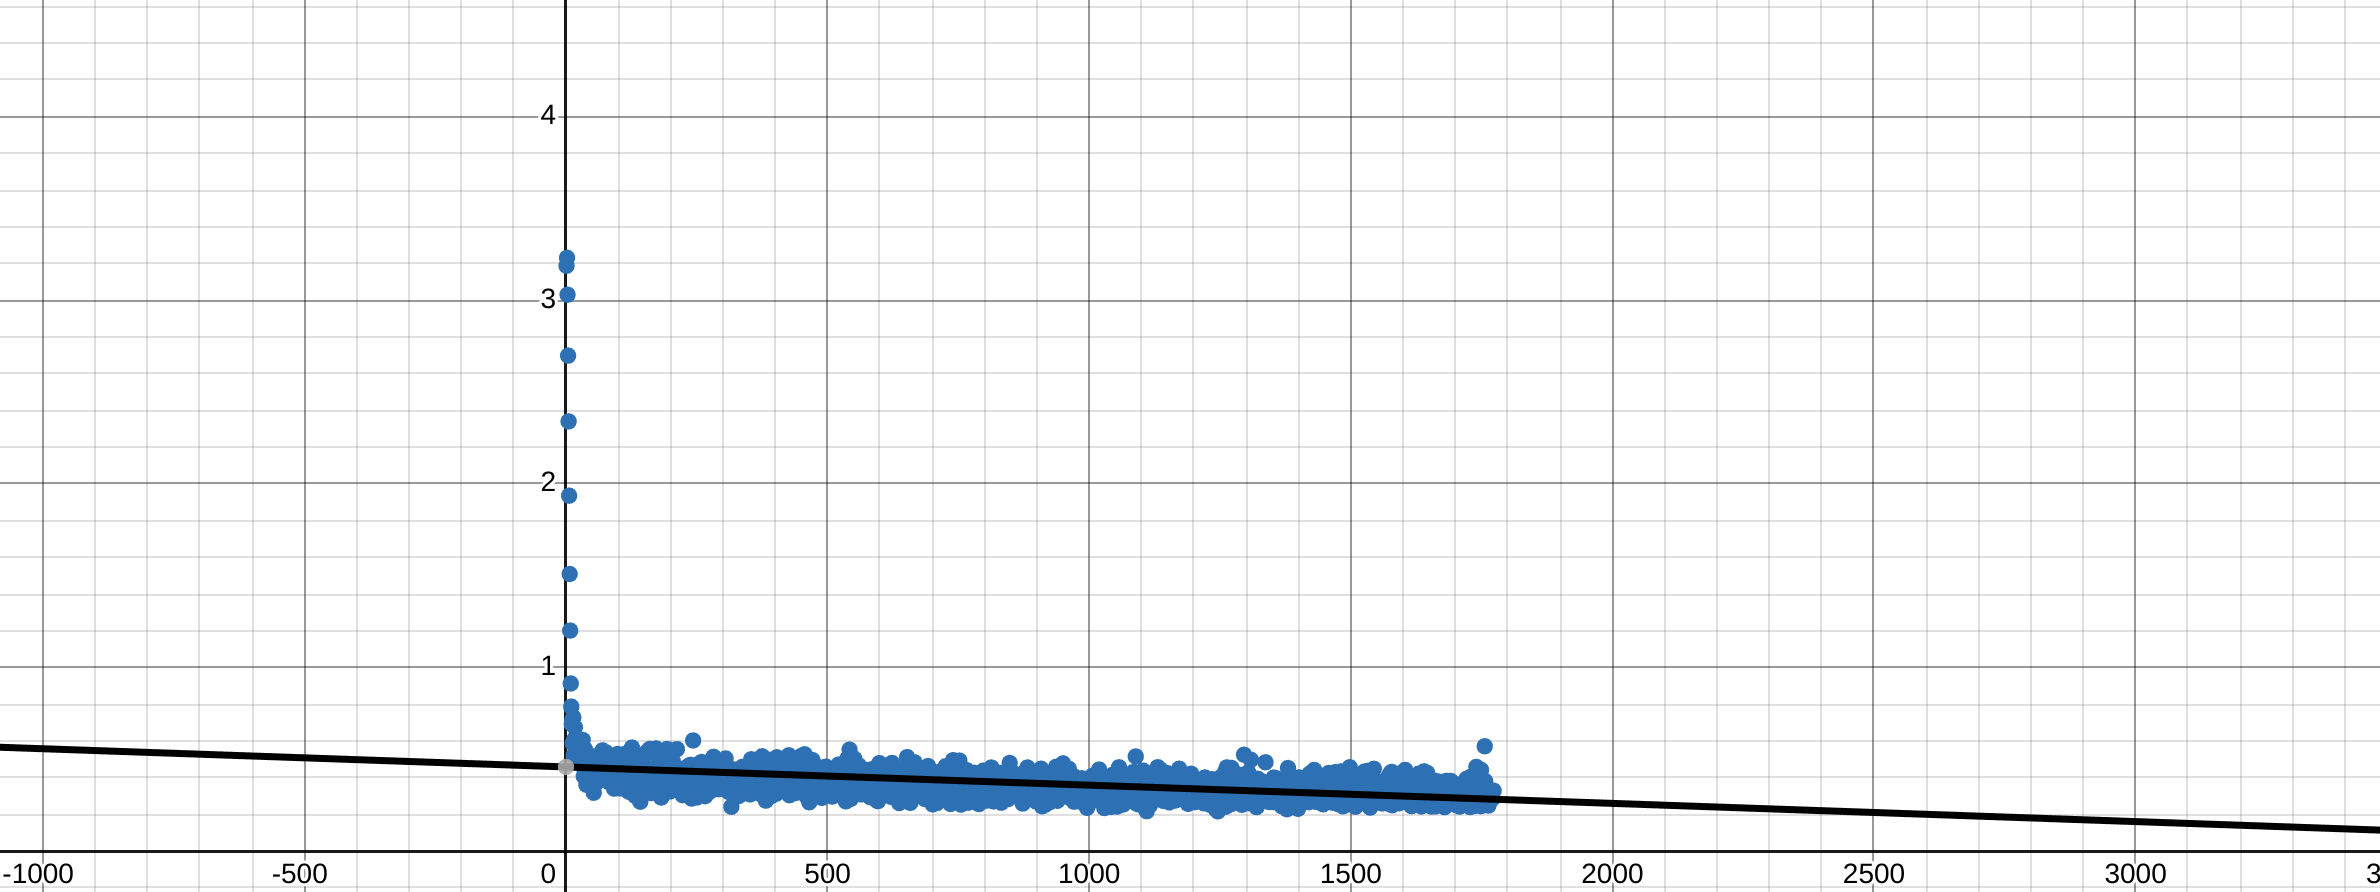


In [7]:
trainer_stats = trainer.train()

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs = 1
   \\   /|    Num examples = 14,190 | Num Epochs = 1
O^O/ \_/ \    Batch size per device = 2 | Gradient Accumulation steps = 4
\        /    Total batch size = 8 | Total steps = 100
 "-____-"     Number of trainable parameters = 41,943,040


Step,Training Loss
1,3.188100
2,3.231200
3,3.030300
4,2.698600
5,2.340500
6,1.935900
7,1.509500
8,1.203600
9,0.917200
10,0.790400


In [52]:

FastLanguageModel.for_inference(model) # Enable native 2x faster inference
inputs = tokenizer(
[
    alpaca_prompt.format(
          "Given a grocery store product, return the section of the store it would be found in.", # instruction
        "Everything Bagel", #input
        "", # output - leave this blank for generation!
    )
], return_tensors = "pt").to("cuda")

outputs = model.generate(**inputs, max_new_tokens = 64, use_cache = True, temperature=0.1)
tokenizer.batch_decode(outputs)

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


['<|begin_of_text|>Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.\n\n### Instruction:\nGiven a grocery store product, return the section of the store it would be found in.\n\n### Input:\nEverything Bagel\n\n### Response:\nBread & Bakery Products<|end_of_text|>']

In [9]:
tokenizer.model_max_length


8192

# Saving and Inference

use the following cells to save the trained lora adaptors and if running on colab save the outputs

In [10]:
model.save_pretrained("lora_model") # Local saving
tokenizer.save_pretrained("lora_model")

('lora_model/tokenizer_config.json',
 'lora_model/special_tokens_map.json',
 'lora_model/tokenizer.json')

Note: The following commented out code will fail if you do not have enough VRAM on your device. Run the following in another Virtual Machie instance. Don't forget to download the lora model weights. Zip and take entire lora_model directory

In [54]:
# from unsloth import FastLanguageModel
# model, tokenizer = FastLanguageModel.from_pretrained(
#         model_name = "lora_model", # YOUR MODEL YOU USED FOR TRAINING
#         max_seq_length = max_seq_length,
#         dtype = dtype,
#         load_in_4bit = load_in_4bit,
#     )
# FastLanguageModel.for_inference(model) # Enable native 2x faster inference

# # alpaca_prompt = You MUST copy from above!

# inputs = tokenizer(
# [
#     alpaca_prompt.format(
#        "Given a grocery store product, return the section of the store it would be found in.", # instruction
#         "Vitamin D3 30 tablest by Jamieson", #input
#         "", # output - leave this blank for generation!
#     )
# ], return_tensors = "pt").to("cuda")

outputs = model.generate(**inputs, max_new_tokens = 64, use_cache = True)
tokenizer.batch_decode(outputs)

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


['<|begin_of_text|>Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.\n\n### Instruction:\nGiven a grocery store product, return the section of the store it would be found in.\n\n### Input:\nEverything Bagel\n\n### Response:\nBread & Bakery Products<|end_of_text|>']